In [1]:
from openmmtools.constants import kB
from simtk import unit
import numpy as np
from tqdm import tqdm
from IPython.core.display import display, HTML
from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import Chem
import copy
import random, math
import os
from neutromeratio.utils import * 
import pickle
import mdtraj as md
import matplotlib.pyplot as plt
from pymbar import BAR

# temperature, mass, and related constants
temperature = 300 * unit.kelvin
kT = kB * temperature
mass = (12.0 * unit.dalton)
sigma_v = np.sqrt(kB * temperature / mass)

# openmm units
mass_unit = unit.dalton
distance_unit = unit.nanometer
time_unit = unit.femtosecond
energy_unit = unit.kilojoule_per_mole
speed_unit = distance_unit / time_unit
force_unit = unit.kilojoule_per_mole / unit.nanometer

# ANI-1 units and conversion factors
ani_distance_unit = unit.angstrom
hartree_to_kJ_mol = 2625.499638
ani_energy_unit = hartree_to_kJ_mol * unit.kilojoule_per_mole # simtk.unit doesn't have hartree?
nm_to_angstroms = (1.0 * distance_unit) / (1.0 * ani_distance_unit)
angstroms_to_nm = (0.1 * ani_distance_unit) / (1.0 * distance_unit)       

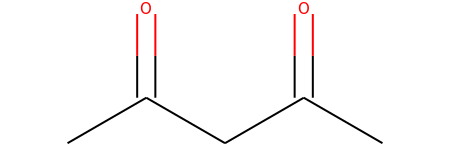

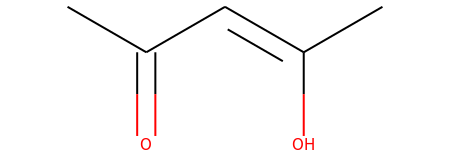

In [32]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'

# specify a run number
nr_of_runs = 5
t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

m1 = Chem.MolFromSmiles(t1_smiles)
AllChem.Compute2DCoords(m1)
display(m1)
Draw.MolToFile(m1,f"../data/md_mc_sampling/{name}/{name}_t1.svg")

m2 = Chem.MolFromSmiles(t2_smiles)
AllChem.Compute2DCoords(m2)
display(m2)
Draw.MolToFile(m2,f"../data/md_mc_sampling/{name}/{name}_t2.svg")


Considering run: 1
Considering run: 2
Considering run: 3
Considering run: 4
Considering run: 5


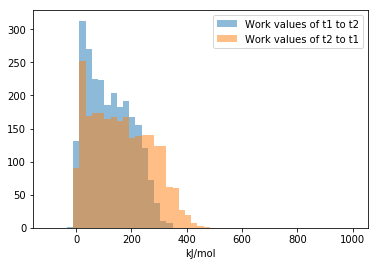

BAR estimate from 2500 work samples in each direction:
	DeltaF = -1.040
	dDeltaF = 0.321


In [34]:
work_values_t1 = []
work_values_t2 = []
nr_of_mc_moves_t1 = 0
nr_of_mc_moves_t2 = 0
for run in range(1, nr_of_runs+1):
    print(f"Considering run: {run}")
    try:
        f = open(f"../data/md_mc_sampling/{name}/{name}_from_t1_to_t2_run{run}_work.csv", 'r')
    except FileNotFoundError:
        continue
    for l in f:
        ts, work_value = l.split(',')
        energy_kJ_mol = (float(work_value)*kT).in_units_of(unit.kilojoule_per_mole)
        work_values_t1.append(energy_kJ_mol._value)
        nr_of_mc_moves_t1+=1

    try:
        f = open(f"../data/md_mc_sampling/{name}/{name}_from_t2_to_t1_run{run}_work.csv", 'r')
    except FileNotFoundError:
        continue
    for l in f:
        ts, work_value = l.split(',')
        energy_kJ_mol = (float(work_value)*kT).in_units_of(unit.kilojoule_per_mole)
        work_values_t2.append(energy_kJ_mol._value)
        nr_of_mc_moves_t2+=1
        
plt.hist(work_values_t1, np.linspace(-100, 1000), label='Work values of t1 to t2', alpha=0.5)
plt.hist(work_values_t2, np.linspace(-100, 1000),label='Work values of t2 to t1', alpha=0.5)
plt.xlabel('kJ/mol')
plt.legend()
plt.savefig(f"../data/md_mc_sampling//{name}/mc_work_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print('BAR estimate from {} work samples in each direction:\n\tDeltaF = {:.3f}\n\tdDeltaF = {:.3f}'.format(nr_of_mc_moves_t1, *BAR(np.asarray(work_values_t1), np.asarray(work_values_t2))))


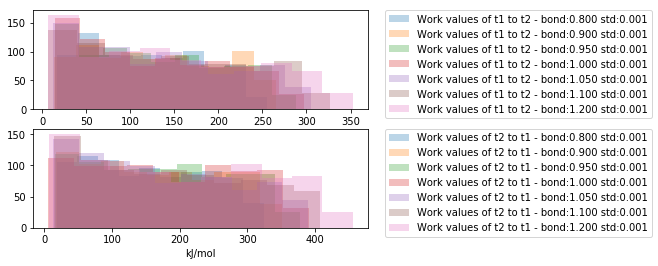

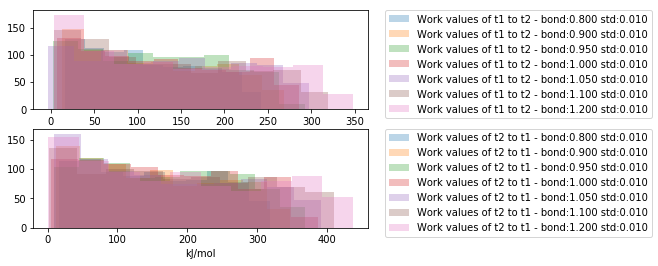

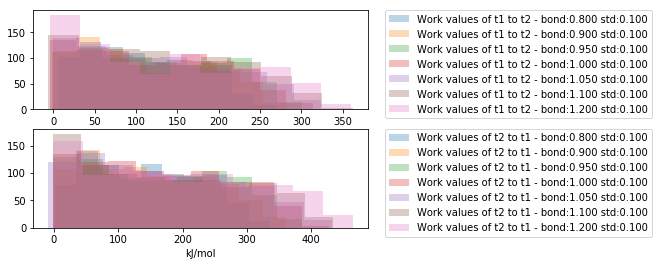

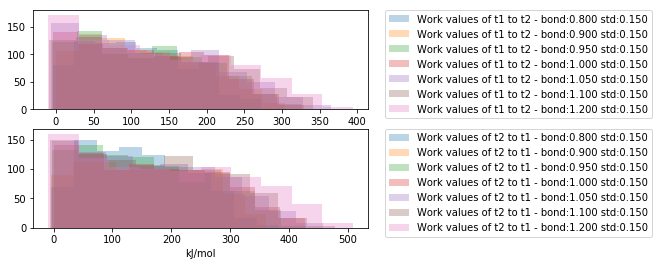

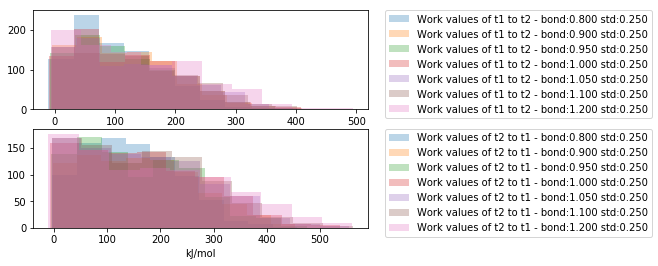

In [44]:
for std in [0.001, 0.01, 0.1, 0.15, 0.25]:
    for mod_bond_length in [0.8,0.9,0.95,1.0, 1.05, 1.1,1.2]:

        nr_of_mc_moves_t1 = 0
        nr_of_mc_moves_t2 = 0
        work_values_t1 = []
        work_values_t2 = []
        for run in range(1, nr_of_runs+1):
            try:
                f = open(f"../data/md_mc_sampling/{name}/{name}_from_t1_to_t2_run{run}_work_bond_length{mod_bond_length}_std{std}.csv", 'r')
                for l in f:
                    ts, work_value = l.split(',')
                    energy_kJ_mol = (float(work_value)*kT).in_units_of(unit.kilojoule_per_mole)
                    work_values_t1.append(energy_kJ_mol._value)
                    nr_of_mc_moves_t1+=1
                f = open(f"../data/md_mc_sampling/{name}/{name}_from_t2_to_t1_run{run}_work_bond_length{mod_bond_length}_std{std}.csv", 'r')
                for l in f:
                    ts, work_value = l.split(',')
                    energy_kJ_mol = (float(work_value)*kT).in_units_of(unit.kilojoule_per_mole)
                    work_values_t2.append(energy_kJ_mol._value)
                    nr_of_mc_moves_t2+=1


            except FileNotFoundError:
                continue
        plt.subplot(2, 1, 1)
        plt.hist(work_values_t1,  label=f"Work values of t1 to t2 - bond:{mod_bond_length:.3f} std:{std:.3f}", alpha=0.3)
        plt.subplot(2, 1, 2)
        plt.hist(work_values_t2, label=f"Work values of t2 to t1 - bond:{mod_bond_length:.3f} std:{std:.3f}", alpha=0.3)

    plt.subplot(2, 1, 1)
    plt.xlabel('kJ/mol')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.subplot(2, 1, 2)
    plt.xlabel('kJ/mol')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    #plt.savefig(f"../data/md_mc_sampling//{name}/mc_work_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
        

#print('BAR estimate from {} work samples in each direction:\n\tDeltaF = {:.3f}\n\tdDeltaF = {:.3f}'.format(nr_of_mc_moves_t1, *BAR(np.asarray(work_values_t1), np.asarray(work_values_t2))))
